# Analiza liczby pasażerów transportu kolejowego
#### Autorzy: Szymon Kowalski, Zuzanna Czyżowska - zespół 18
## 1. Wprowadzenie i cel analizy

W tym projekcie zajmiemy się analizą systemów kolejowych w państwach europejskich, w celu określenia czynników wpływających na roczną liczbę pasażerów transportu kolejowego w danym państwie. Korzystając z danych zebranych przez Eurostat w latach 2013-2023 dotyczących m.in. infrastruktury kolejowej, liczby pojazdów kolejowych, sytuacji ekonomicznej w kraju, wielkości inwestycji w transport kolejowy, spróbujemy zdefiniować najistotniejsze cechy, od których zależna jest liczba pasażerów kolei. Następnie na podstawie otrzymanych wyników stworzymy model regresji, mający na celu przewidywanie liczby użytkowników kolei w danym roku w danym kraju.

Źródło danych: https://ec.europa.eu/eurostat/databrowser/explore/all/transp?lang=en&subtheme=rail&display=list&sort=category

## 2. Hipoteza badawcza


## 3. Załadowanie danych

Import potrzebnych bibliotek:

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Wczytanie i przygotowanie danych:

In [98]:
tables = pd.read_excel('all_data.xlsx', sheet_name='Arkusz3')
tables = tables.dropna(axis=0, how='all')
tables = tables.dropna(axis=1, how='all')

print("Dane:")
print(tables.head())
print("Rozmiar danych:")
print(tables.shape)

Dane:
   n  year   country    pa_tr pa_tr_na pa_tr_in    tr_tr  le_ra_tr  \
0  1  2013   Belgium        :        :        :        :      6256   
1  2  2013  Bulgaria    26059    25727      332  25456.3      6517   
2  3  2013   Czechia   174189   170790     3399   127109     15607   
3  4  2013   Denmark   193500   181151    12349    67045         :   
4  5  2013   Germany  2612764  2597616    15148   776000  70425.16   

  le_ra_tr_el le_ra_tr_nel  ...  ca_co  ca_ra    ex_in    in_in        po  \
0           :            :  ...      :      :        :        :  11137974   
1           :            :  ...  27.44  59.44      138        :   7202556   
2        6926         8681  ...    147    138  712.433  377.675  10516125   
3           :            :  ...    134      7  564.636  381.475   5602628   
4   41423.245    29001.915  ...      :      :        :     4535  80523746   

  in_ra gdp_pc co_pr_le  le_mo   n_pa_air  
0   1.2  33350    111.8   1763   26389927  
1   0.4   5470     50.

### Opis zbioru:
Każda obserwacja występuje dla danego europejskiego kraju  w danym roku (od 2013 do 2023). W zbiorze widać, że jest 30 kolumn:
- n - numer obserwacji,
- year - rok obserwacji (dane są zbierane na stan 1 stycznia danego roku)
- country - kraj

Nasza kolumna-klasa (jednostka):
- pa_tr - przewiezieni pasażerowie (tys.)

Pozostałe kolumny to cechy, których wpływ na naszą klasę będziemy sprawdzać i możemy podzielić je na kategorie:

a) Transport kolejowy
- pa_tr_na - przewiezieni pasażerowie w transporcie krajowym (tys.)
- pa_tr_in - przewiezieni pasażerowie w transporcie międzynarodowym (tys.)
- tr_tr - praca przewozowa pociągów (tys. pociągokm-ile pociągów przebyło 1 km)

b) Infrastruktura kolejowa:
- le_ra_tr - długość torów kolejowych (km)
- le_ra_tr_el - długość torów zelektryfikowanych (km)
- le_ra_tr_nel - długość torów niezelektryfikowanych (km)
- le_li - długość linii kolejowych (km)
- le_el_li - długość linii kolejowych zelektryfikowanych (km)
- le_nel_li - długość linii kolejowych niezelektryfikowanych (km)
- le_li_hi - długość dedykowanych linii kolei dużych prędkości (powyżej 250 km/h) (km)
- le_li_up_hi - długość zmodernizowanych linii kolei dużych prędkości (200-250 km/h) (km)

c) Sprzęt
- n_ve - liczba pociągów pasażerskich (liczba)
- n_co_tr - liczba wagonów (liczba)
- n_ra - liczba szynobusów (liczba)
- n_sl_ca - liczba wagonów sypialnych (liczba)
- n_di_ca - liczba wagonów restauracyjnych (liczba)
- n_lo_di - liczba lokomotyw spalinowych (liczba)
- n_ra_di - liczba szynobusów spalinowych (liczba)
- n_lo_el - liczba lokomotyw elektrycznych (liczba)
- n_ra_el - liczba szynobusów elektrycznych (liczba)
- ca_ve - pojemność pasażerskich pojazdów kolejowych (tys. miejsc)
- ca_co - pojemność wagonów (tys. miejsc)
- ca_ra - pojemność szynobusów (tys. miejsc)

d) Stan demograficzny i ekonomiczny w danym kraju
- po - populacja kraju (liczba)
- gdp_pc - PKB per capita (euro)
- co_pr_le - porównawcze poziomy cen w danym kraju (wskaźnik poziomu cen, UE-27 = 100) - ta cecha ma na celu pokazanie, czy dany kraj jest droższy lub tańszy w porównaniu do średniej unijnej, poniżej 100 - jest tańszy, powyżej 100 - droższy
- in_ra - stopa inflacji (HICP-zharmonizowany wskaźnik cen konsumpcyjnych)

e) Wydatki i inwestycje
- ex_in - wydatki na infrastrukturę (mln euro) - utrzymanie, konserwacja, naprawy itp.
- in_in - inwestycje w infrastrukturę (mln euro)

f) Konkurencja
- le_mo - długość autostrad (km)
- n_pa_air - liczba pasażerów na pokładzie samolotów (odloty i przyloty w danym kraju) (liczba pasażerów)

## 4. Analiza jakości danych

Przekonwertowanie na odpowiednie typy danych.

In [99]:
tables[['n', 'country']] = tables[['n', 'country']].astype(str)
tables['year'] = pd.to_datetime(tables['year'], format='%Y')

columns_to_convert = tables.columns[3:]
for col in columns_to_convert:
    tables[col] = tables[col].astype(str).str.strip().str.replace(",", ".", regex=False)
    tables[col] = pd.to_numeric(tables[col], errors='coerce')

print(tables.dtypes)

n                       object
year            datetime64[ns]
country                 object
pa_tr                  float64
pa_tr_na               float64
pa_tr_in               float64
tr_tr                  float64
le_ra_tr               float64
le_ra_tr_el            float64
le_ra_tr_nel           float64
le_li                  float64
le_el_li               float64
le_nel_li              float64
le_li_hi               float64
le_li_up_hi            float64
n_ve                   float64
n_co_tr                float64
n_ra                   float64
n_sl_ca                float64
n_di_ca                float64
n_lo_di                float64
n_ra_di                float64
n_lo_el                float64
n_ra_el                float64
ca_ve                  float64
ca_co                  float64
ca_ra                  float64
ex_in                  float64
in_in                  float64
po                     float64
in_ra                  float64
gdp_pc                 float64
co_pr_le

Sprawdzenie ile jest braków w danych

In [100]:
print("Braki danych: \n", tables.isnull().sum())

Braki danych: 
 n                 0
year              0
country           0
pa_tr            38
pa_tr_na         35
pa_tr_in         38
tr_tr            37
le_ra_tr         43
le_ra_tr_el      72
le_ra_tr_nel     72
le_li             1
le_el_li          1
le_nel_li         1
le_li_hi          2
le_li_up_hi       6
n_ve            100
n_co_tr         119
n_ra            114
n_sl_ca         154
n_di_ca         159
n_lo_di          91
n_ra_di         111
n_lo_el          92
n_ra_el         111
ca_ve           139
ca_co           176
ca_ra           177
ex_in           154
in_in           151
po                3
in_ra             4
gdp_pc            5
co_pr_le          1
le_mo            17
n_pa_air         16
dtype: int64


Widzimy, że występuje wiele braków danych w tym zbiorze. Zanim, więc przejdziemy do dalszej analizy, należy zdecydować co z nimi zrobić. Najpierw sprawdzimy jakie są braki dla danych cech.

In [101]:
missing_percentage = tables.isnull().mean()
threshold = 0.4
columns_with_big_missing = missing_percentage[missing_percentage > threshold]
print(columns_with_big_missing)

n_sl_ca    0.466667
n_di_ca    0.481818
ca_ve      0.421212
ca_co      0.533333
ca_ra      0.536364
ex_in      0.466667
in_in      0.457576
dtype: float64


Patrząc na wyniki, na pewno można z naszego zbioru usunąć cechy: n_sl_ca (liczba wagonów sypialnych), n_di_ca (liczba wagonów restauracyjnych). Dla nich brakuje prawie połowy danych, więc imputacja mogłaby bardzo zakrzywić wyniki. Dla ca_ve (pojemność pociągów) również są duże braki, ale możemy spróbować przeprowadzić imputacje. Natomiast ca_co i ca_ra, które rozdzielają pojemność dla wagonów i szynobusów ma braki powyżej połowy, więc również należy je usunąć. Jeśli chodzi o ex_in i in_in, te również mają braki wynoszące około 45%, natomiast opisują one wydatki i inwestycje w infrastrukturę kolei i mogą być zbyt istotne, aby je usunąć. Dlatego na nich również spróbujemy przeprowadzić imputacje.

In [102]:
columns_to_drop = ['n_sl_ca', 'n_di_ca', 'ca_co', 'ca_ra']

tables_cleaned_col = tables.drop(columns=columns_to_drop)

Teraz sprawdzimy, czy duże braki danych nie występują po prostu dla konkretnych państw, wtedy możnaby również je usunąć ze zbioru, ponieważ nie przynosiłyby dużo informacji i nie będzie można w przyszłości dla nich przeprowadzić predykcji.

In [103]:
missing_in_row = tables_cleaned_col.isnull().mean(axis=1)

threshold = 0.3
rows_with_many_nans = tables_cleaned_col[missing_in_row > threshold]

country_stats = rows_with_many_nans.groupby('country').agg(
    liczba_obserwacji=('country', 'size'),
    sredni_procent_brakow=('country', lambda x: rows_with_many_nans.loc[x.index].isnull().mean(axis=1).mean() * 100)
)

print("Kraje z brakami danych powyżej 30%, liczba takich obserwacji oraz średni procent braków:")
for country, row in country_stats.iterrows():
    print(f"Kraj: {country}, Liczba obserwacji: {row['liczba_obserwacji']}, Średni procent braków: {row['sredni_procent_brakow']:.2f}%")

Kraje z brakami danych powyżej 30%, liczba takich obserwacji oraz średni procent braków:
Kraj: Belgium, Liczba obserwacji: 11.0, Średni procent braków: 48.39%
Kraj: Bulgaria, Liczba obserwacji: 9.0, Średni procent braków: 39.07%
Kraj: Germany, Liczba obserwacji: 1.0, Średni procent braków: 32.26%
Kraj: Ireland, Liczba obserwacji: 6.0, Średni procent braków: 33.87%
Kraj: Italy, Liczba obserwacji: 1.0, Średni procent braków: 32.26%
Kraj: Netherlands, Liczba obserwacji: 10.0, Średni procent braków: 39.35%
Kraj: Norway, Liczba obserwacji: 3.0, Średni procent braków: 38.71%
Kraj: Spain, Liczba obserwacji: 1.0, Średni procent braków: 32.26%
Kraj: Switzerland, Liczba obserwacji: 11.0, Średni procent braków: 40.76%
Kraj: Türkiye, Liczba obserwacji: 3.0, Średni procent braków: 43.01%
Kraj: United Kingdom, Liczba obserwacji: 4.0, Średni procent braków: 50.81%


Ze względu na to, że niektóre państwa dla każdego roku mają duże braki danych, możemy z naszej analizy wyrzucić Belgię, Bułgarię, Holandię oraz Szwajcarię. U reszty państw występują braki dla nielicznych obserwacji, więc możemy je zostawić.

In [104]:
countries_to_remove = [ 'Belgium', 'Bulgaria', 'Netherlands', 'Switzerland']

tables_cleaned_col_row = tables_cleaned_col[~tables['country'].isin(countries_to_remove)]
print("Braki danych: \n", tables_cleaned_col_row.isnull().sum())

Braki danych: 
 n                 0
year              0
country           0
pa_tr            16
pa_tr_na         13
pa_tr_in         16
tr_tr            18
le_ra_tr         32
le_ra_tr_el      39
le_ra_tr_nel     39
le_li             1
le_el_li          1
le_nel_li         1
le_li_hi          2
le_li_up_hi       6
n_ve             62
n_co_tr          78
n_ra             71
n_lo_di          52
n_ra_di          72
n_lo_el          53
n_ra_el          72
ca_ve            96
ex_in           124
in_in           112
po                3
in_ra             4
gdp_pc            5
co_pr_le          1
le_mo            14
n_pa_air         16
dtype: int64


Po usunięciu kolumn i rzędów, niosących niewiele informacji, możemy przejść do przeprowadzenia imputacji dla wszystkich cech. Wybraliśmy metodę imputacji bfill - czyli uzupełnienie braków na podstawie ostatniej danej z przeszłości. Ta metoda może być najbezpieczniejsza, ponieważ wartości cech z roku na rok w danym kraju zmieniają się w małej skali.

In [105]:
tables_cleaned_col_row = tables_cleaned_col_row.sort_values(by=['country', 'year'])

tables_imputed = tables_cleaned_col_row.groupby('country', group_keys=False).apply(lambda group: group.bfill().ffill())

tables_imputed.reset_index(drop=True, inplace=True)

tables_imputed = tables_imputed.sort_values(by=['year', 'country'])

print("Braki danych: \n", tables_imputed.isnull().sum())

Braki danych: 
 n                0
year             0
country          0
pa_tr            0
pa_tr_na         0
pa_tr_in         0
tr_tr            0
le_ra_tr        22
le_ra_tr_el     22
le_ra_tr_nel    22
le_li            0
le_el_li         0
le_nel_li        0
le_li_hi         0
le_li_up_hi      0
n_ve            11
n_co_tr         55
n_ra            55
n_lo_di         33
n_ra_di         55
n_lo_el         33
n_ra_el         55
ca_ve           77
ex_in           88
in_in           88
po               0
in_ra            0
gdp_pc           0
co_pr_le         0
le_mo            0
n_pa_air         0
dtype: int64


/var/folders/vl/gs1w498x01bftxkwdxs2z5s80000gn/T/ipykernel_65653/3864024509.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tables_imputed = tables_cleaned_col_row.groupby('country', group_keys=False).apply(lambda group: group.bfill().ffill())


Pomimo imputacji bfill i ffill nadal występują duże braki. O ile cechy ex_in i in_in są bardzo istotne i dla nich przeprowadzimy imputacje przez regresję, o tyle cechy z 'n' na początku określające liczbę różnych pojazdów mogą być zbędne i możemy część z nich usunąć. Cecha określająca długość torów (le_ może być bardzo przydatna, dlatego również zastosujemy na niej imputacje przez regresje.

In [106]:
from sklearn.linear_model import LinearRegression

# Funkcja do imputacji regresją
def imputacja_regresja(df, target_column, feature_columns):

    train_data = df.dropna(subset=[target_column])

    X_train = train_data[feature_columns]
    y_train = train_data[target_column]

    model = LinearRegression()
    model.fit(X_train, y_train)

    missing_data = df[df[target_column].isnull()]
    X_missing = missing_data[feature_columns]
    if len(X_missing) > 0:
        predicted_values = model.predict(X_missing)

        predicted_values = np.clip(predicted_values, a_min=0, a_max=None)

        df.loc[df[target_column].isnull(), target_column] = predicted_values


    return df

# Lista cech do imputacji
rail_features_to_impute = ['n_ve', 'ca_ve','le_ra_tr', 'le_ra_tr_el', 'le_ra_tr_nel', 'n_co_tr', 'n_ra', 'n_lo_di', 'n_ra_di', 'n_lo_el', 'n_ra_el', 'ex_in', 'in_in']

# Predyktory dla długości torów kolejowych
predictors = ['tr_tr', 'le_li', 'le_el_li', 'le_nel_li', 'gdp_pc', 'po']

for feature in rail_features_to_impute:
    tables_imputed = imputacja_regresja(tables_imputed, feature, predictors)

print("Braki danych: \n", tables_imputed.isnull().sum())
# Finalna tabela po imputacji
tables = tables_imputed

Braki danych: 
 n               0
year            0
country         0
pa_tr           0
pa_tr_na        0
pa_tr_in        0
tr_tr           0
le_ra_tr        0
le_ra_tr_el     0
le_ra_tr_nel    0
le_li           0
le_el_li        0
le_nel_li       0
le_li_hi        0
le_li_up_hi     0
n_ve            0
n_co_tr         0
n_ra            0
n_lo_di         0
n_ra_di         0
n_lo_el         0
n_ra_el         0
ca_ve           0
ex_in           0
in_in           0
po              0
in_ra           0
gdp_pc          0
co_pr_le        0
le_mo           0
n_pa_air        0
dtype: int64


Sprawdzenie czy są jakieś duplikaty

In [107]:
print("Duplikaty: \n", tables.duplicated().sum())

Duplikaty: 
 0


## 5. Statystyki opisowe

Podstawowe statystyki dla cech liczbowych (średnia, mediana, odchylenie standardowe, min, max, kwartyle):

In [108]:
print(tables.info)
print(tables.describe())

<bound method DataFrame.info of        n       year         country      pa_tr   pa_tr_na  pa_tr_in  \
0     18 2013-01-01         Austria   235434.0   225063.0   10371.0   
11    11 2013-01-01         Croatia    24216.0    23810.0     406.0   
22     3 2013-01-01         Czechia   174189.0   170790.0    3399.0   
33     4 2013-01-01         Denmark   193500.0   181151.0   12349.0   
44     6 2013-01-01         Estonia     4199.0     4077.0     122.0   
..   ...        ...             ...        ...        ...       ...   
241  322 2023-01-01        Slovenia    14483.0    14039.0     444.0   
252  309 2023-01-01           Spain   666205.0   665205.0    1000.0   
263  325 2023-01-01          Sweden   243442.0   229093.0   14349.0   
274  330 2023-01-01         Türkiye    25610.0    24870.0     740.0   
285  328 2023-01-01  United Kingdom  1836886.0  1816345.0   20541.0   

         tr_tr      le_ra_tr   le_ra_tr_el  le_ra_tr_nel  ...      n_ra_el  \
0    134386.00   9708.000000   8041.0

Analiza cech kategorycznych (u nas tylko kraje):

In [109]:
print(tables['country'].value_counts())

country
Austria            11
Croatia            11
Türkiye            11
Sweden             11
Spain              11
Slovenia           11
Slovakia           11
Romania            11
Portugal           11
Poland             11
Norway             11
North Macedonia    11
Luxembourg         11
Lithuania          11
Latvia             11
Italy              11
Ireland            11
Hungary            11
Greece             11
Germany            11
France             11
Finland            11
Estonia            11
Denmark            11
Czechia            11
United Kingdom     11
Name: count, dtype: int64


## 6. Wizualizacja danych

### 1. Rozkład poszczególnych zmiennych.


<Figure size 1500x800 with 0 Axes>

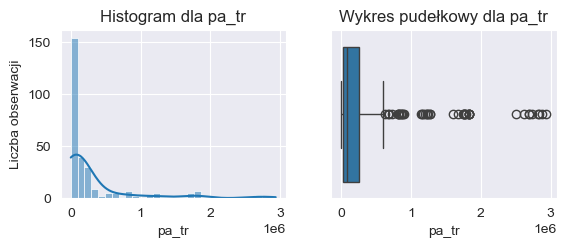

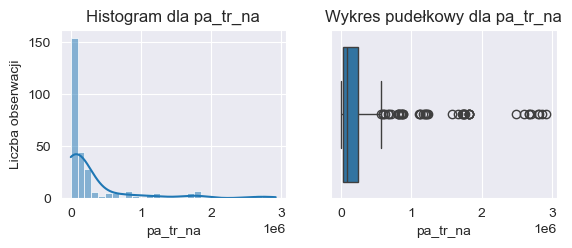

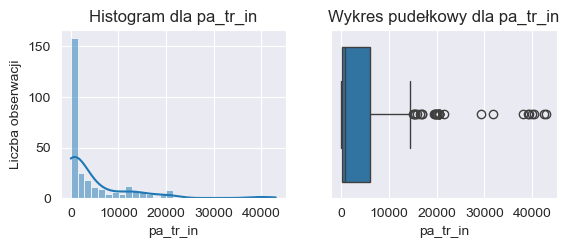

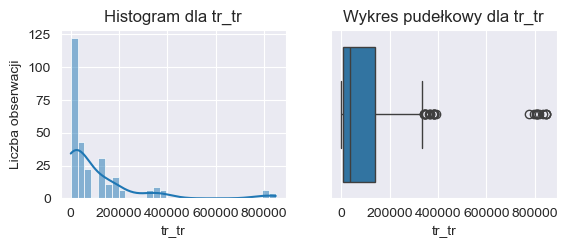

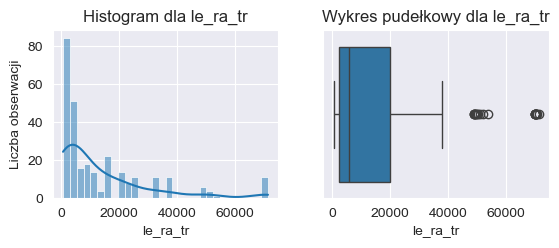

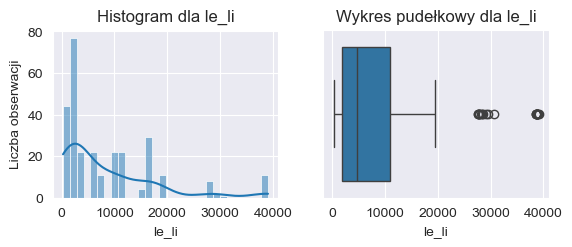

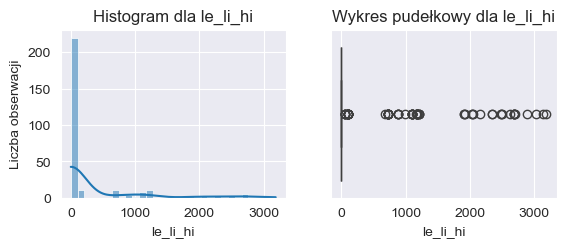

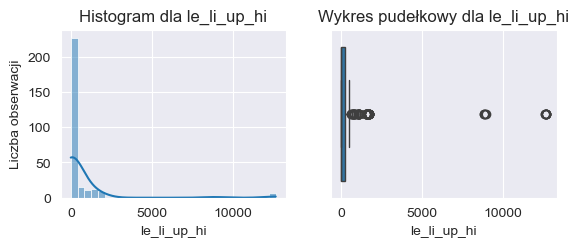

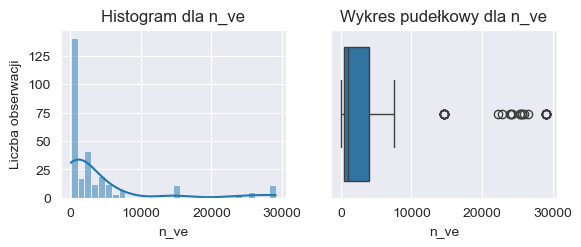

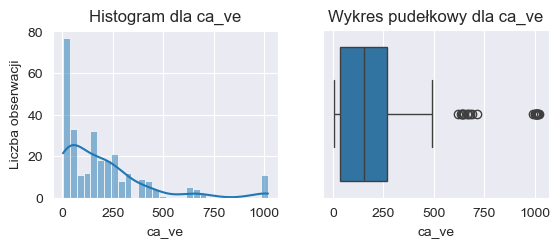

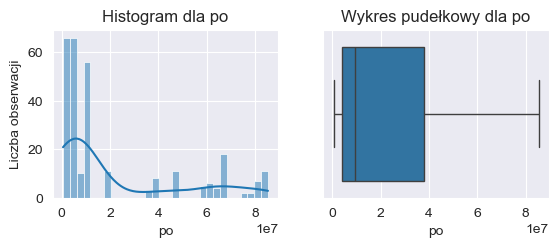

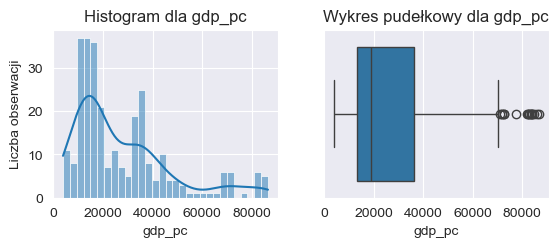

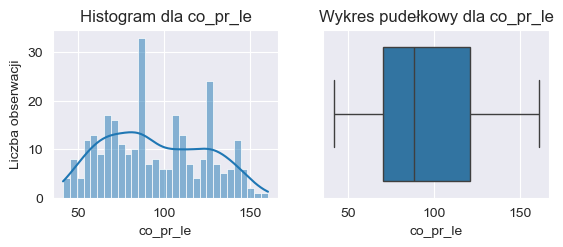

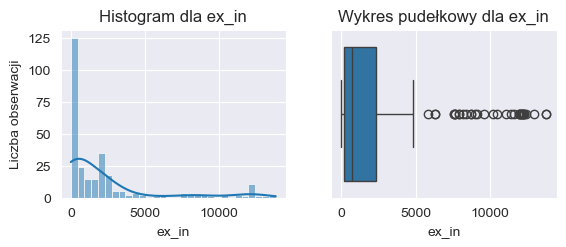

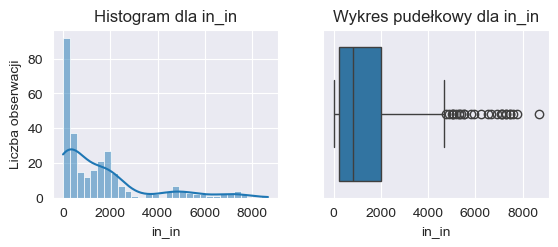

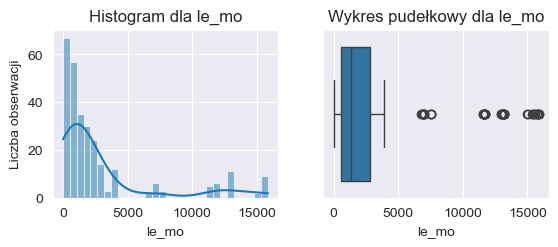

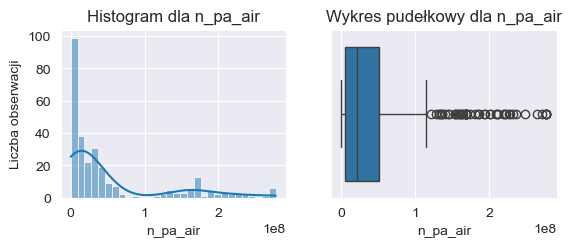

In [110]:
plt.figure(figsize=(15, 8))

features = [
    'pa_tr', 'pa_tr_na', 'pa_tr_in', 'tr_tr',
    'le_ra_tr', 'le_li', 'le_li_hi', 'le_li_up_hi',
    'n_ve', 'ca_ve',
    'po', 'gdp_pc', 'co_pr_le',
    'ex_in', 'in_in',
    'le_mo', 'n_pa_air'
]

for feature in features:
    plt.figure()
    plt.subplot(2, 2, 1)
    sns.histplot(tables[feature].dropna(), kde=True, bins=30)
    plt.title(f"Histogram dla {feature}")
    plt.xlabel(feature)
    plt.ylabel("Liczba obserwacji")

    plt.subplot(2, 2, 2)
    sns.boxplot(x=tables[feature].dropna())
    plt.title(f"Wykres pudełkowy dla {feature}")
    plt.xlabel(feature)

    plt.show()

Praktycznie dla wszystkich cech z wyjątkiem co_pr_le (opisujący, czy kraj jest drogi, czy tani) i ca_ve (opisujący pojemność pociągów), histogramy są wyraźnie prawostronnie skośne. Można było spodziewać się takiej wizualizacji, po otrzymanych wcześniej statystykach opisowych, które pokazywały bardzo dużą wariancję cech. W związku z tym możemy przeprowadzić transformację logarytmiczną, dzięki której wykresy te będą bardziej znormalizowane.

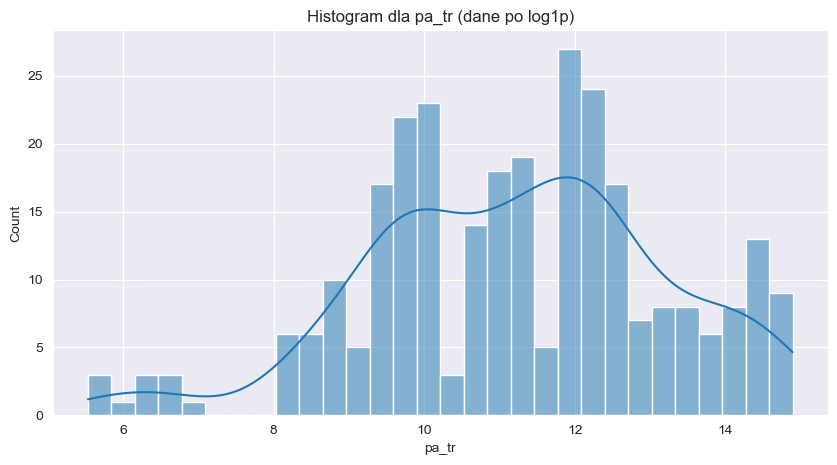

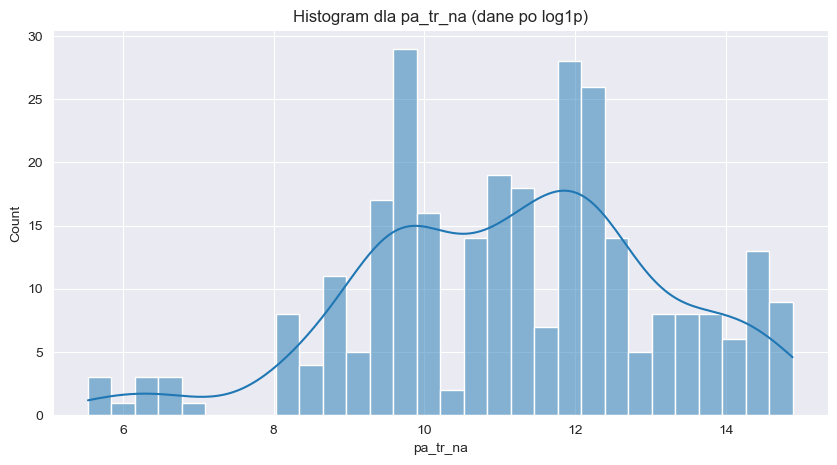

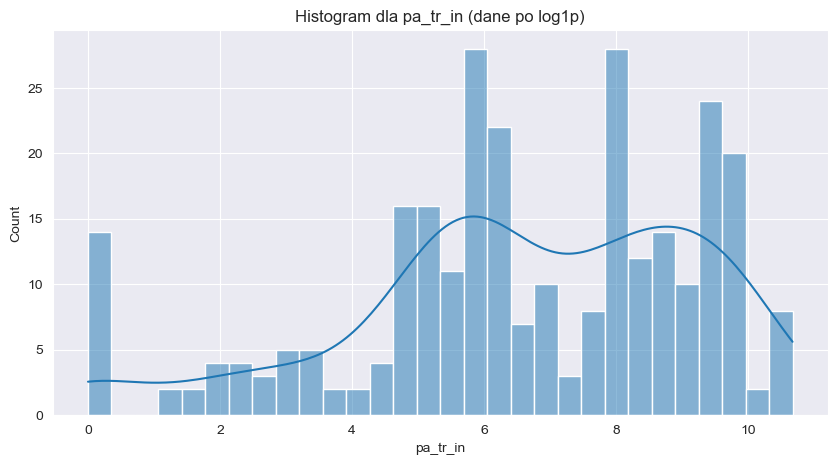

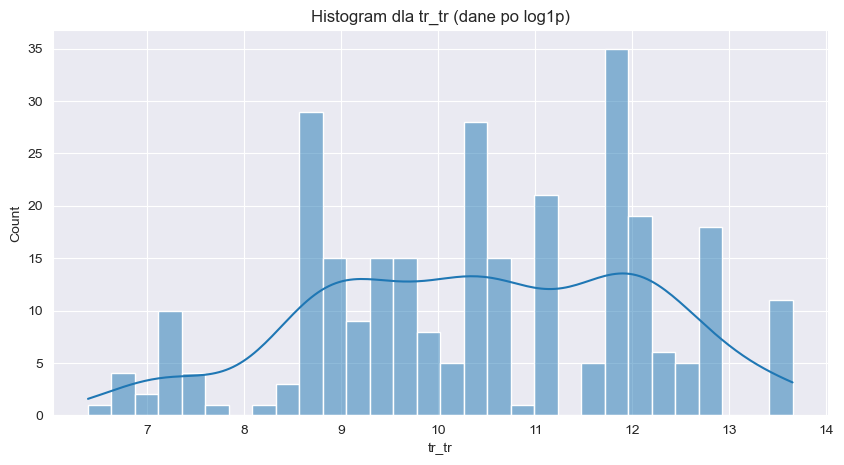

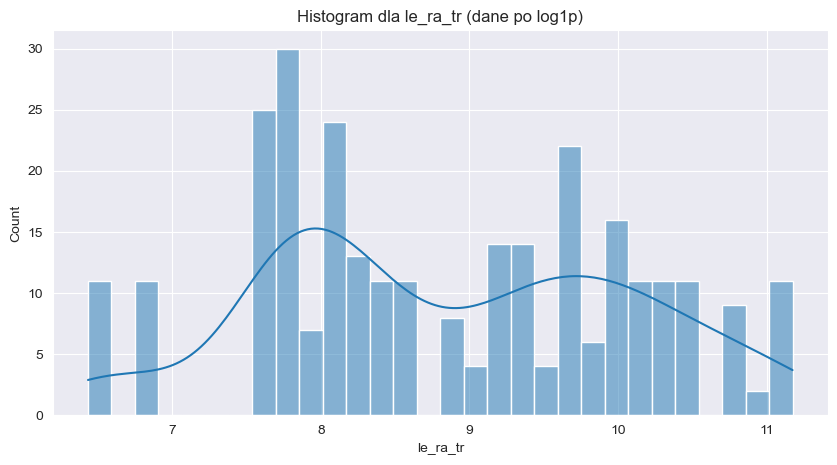

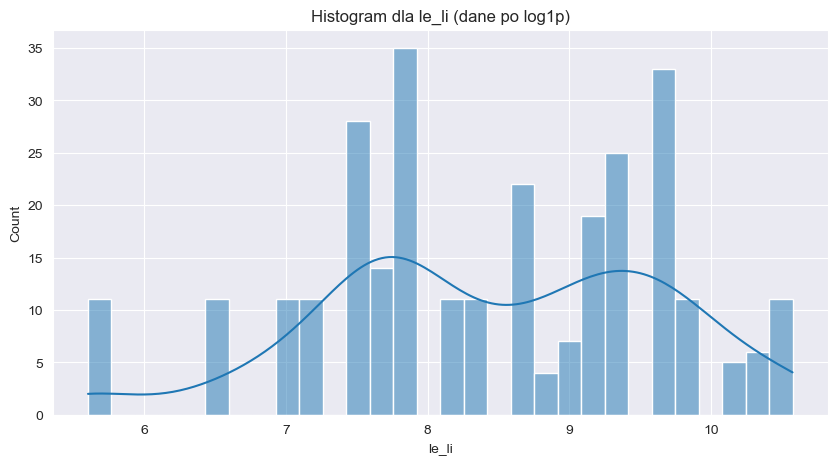

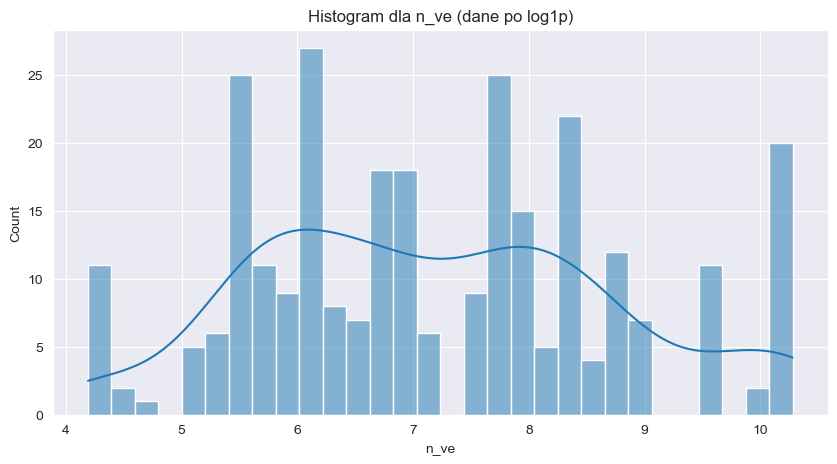

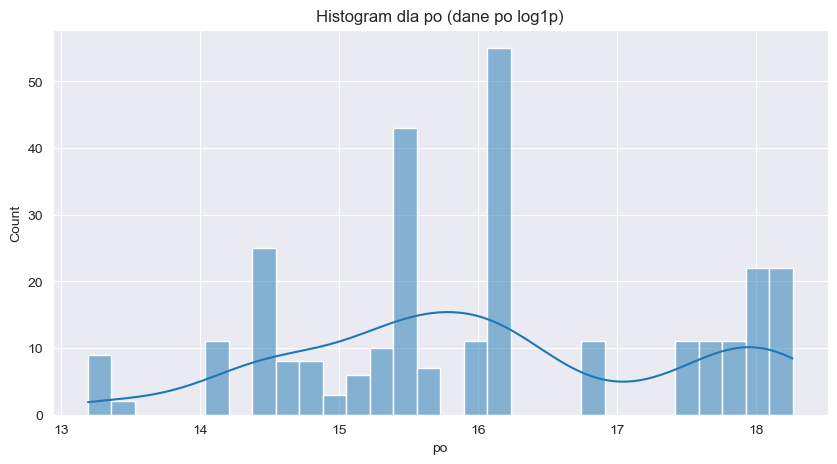

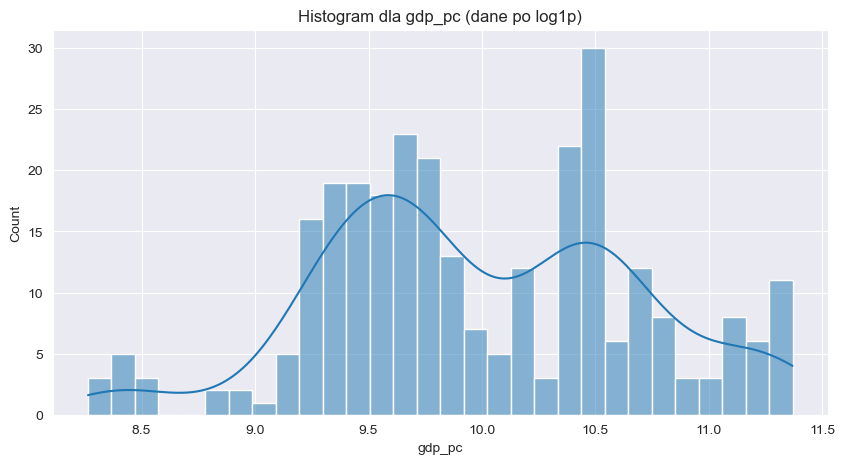

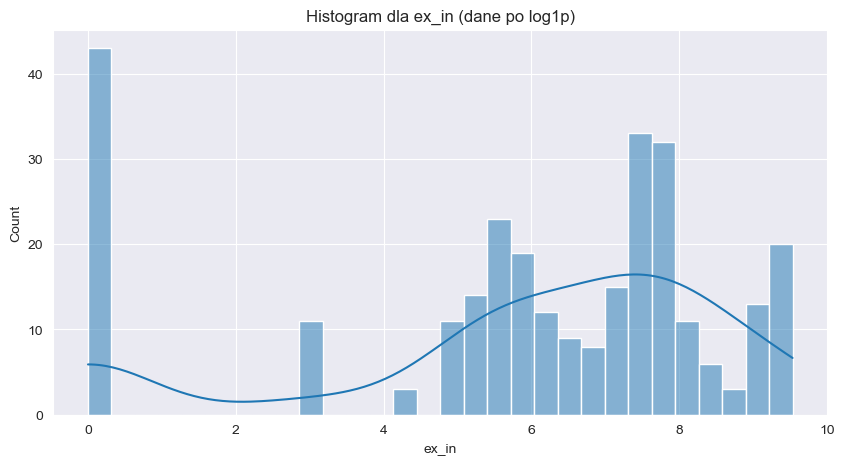

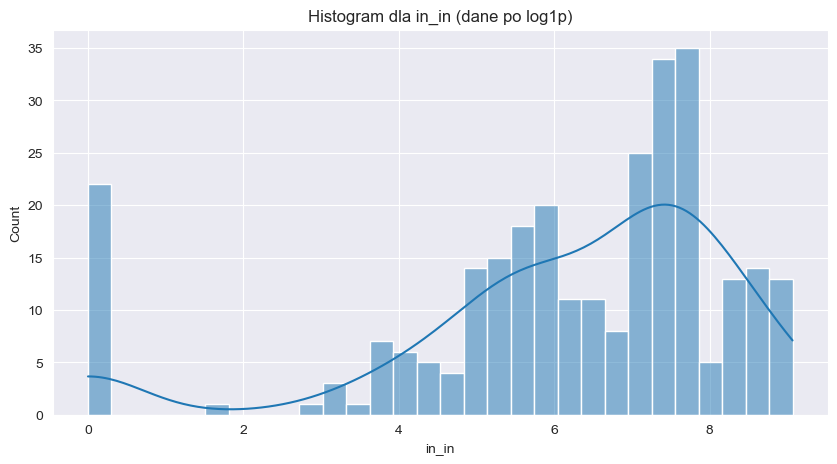

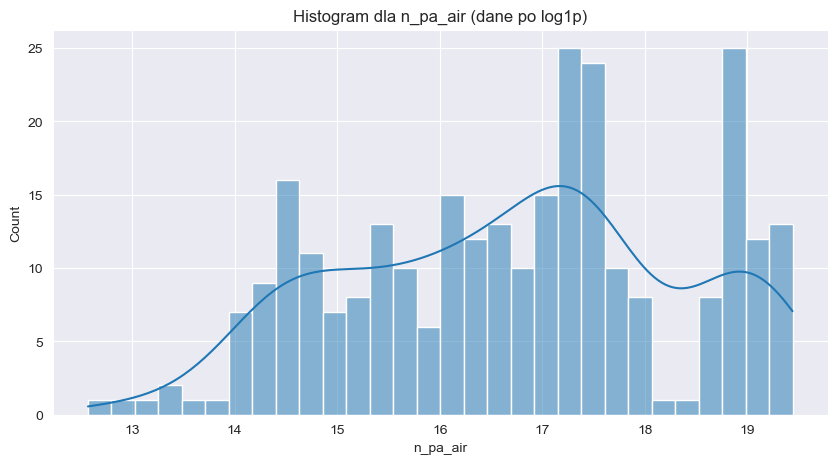

In [111]:
features_to_transform = ['pa_tr', 'pa_tr_na', 'pa_tr_in', 'tr_tr',
    'le_ra_tr', 'le_li', 'n_ve', 'po', 'gdp_pc','ex_in', 'in_in', 'n_pa_air']

for feature in features_to_transform:
    plt.figure(figsize=(10, 5))
    sns.histplot(np.log1p(tables[feature].dropna()), kde=True, bins=30)
    plt.title(f"Histogram dla {feature} (dane po log1p)")

    plt.show()

### 2. Zależności między zmiennymi (scatter ploty i heatmapa korelacji).

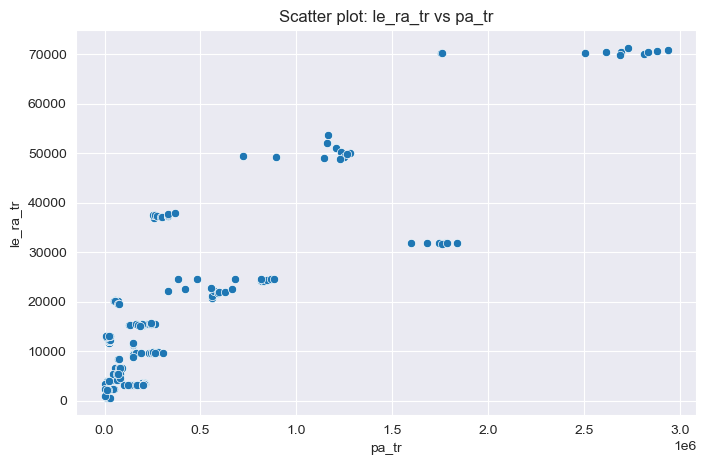

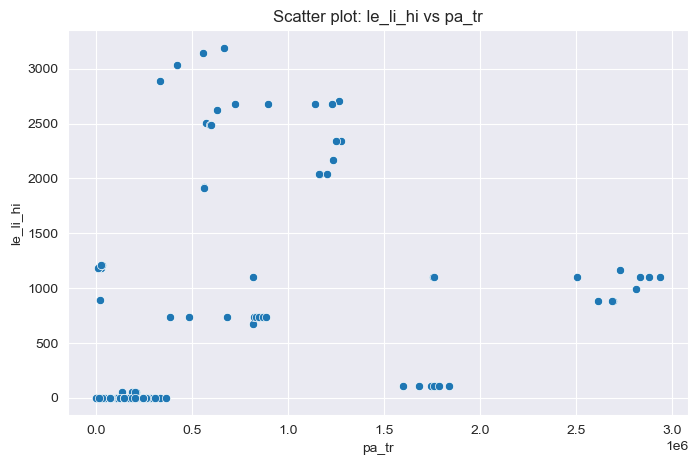

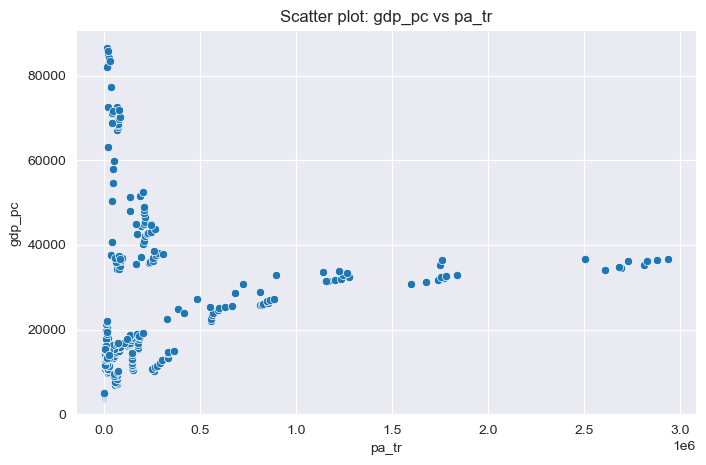

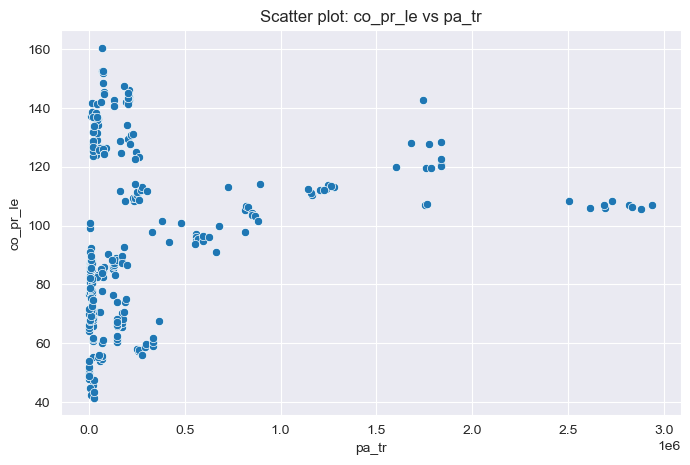

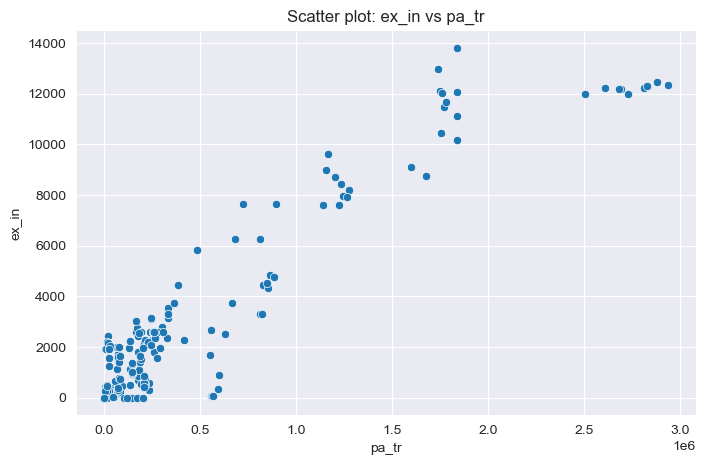

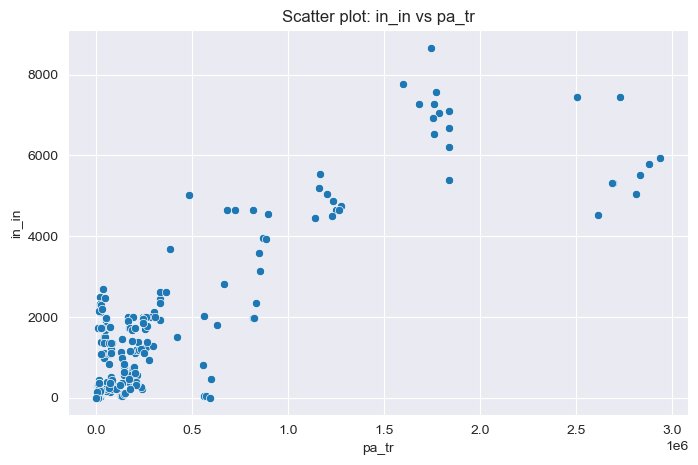

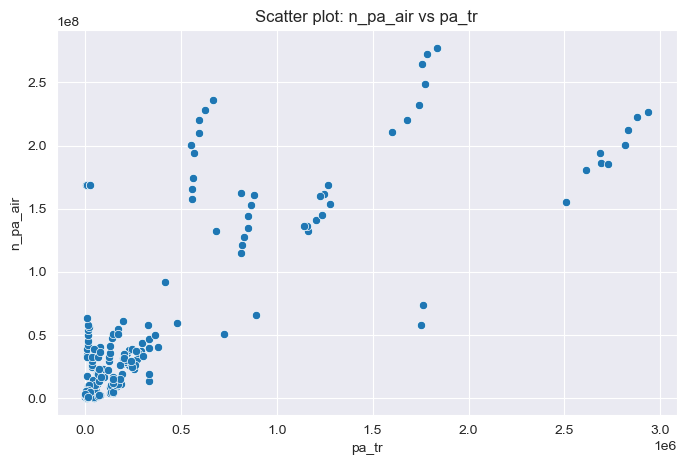

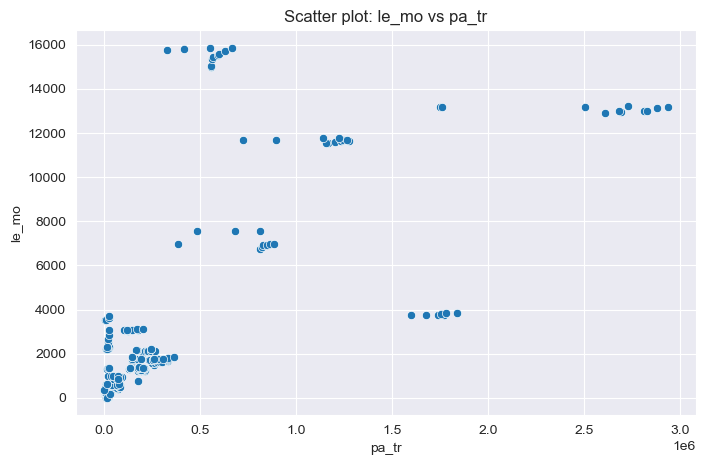

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns

# Wybrane pary zmiennych do analizy
scatter_pairs = [
    ('pa_tr', 'le_ra_tr'),
    ('pa_tr', 'le_li_hi'),
    ('pa_tr', 'gdp_pc'),
    ('pa_tr', 'co_pr_le'),
    ('pa_tr', 'ex_in'),
    ('pa_tr', 'in_in'),
    ('pa_tr', 'n_pa_air'),
    ('pa_tr', 'le_mo'),
]

for x_var, y_var in scatter_pairs:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=tables, x=x_var, y=y_var)
    plt.title(f"Scatter plot: {y_var} vs {x_var}")
    plt.xlabel(x_var)
    plt.ylabel(y_var)
    plt.show()


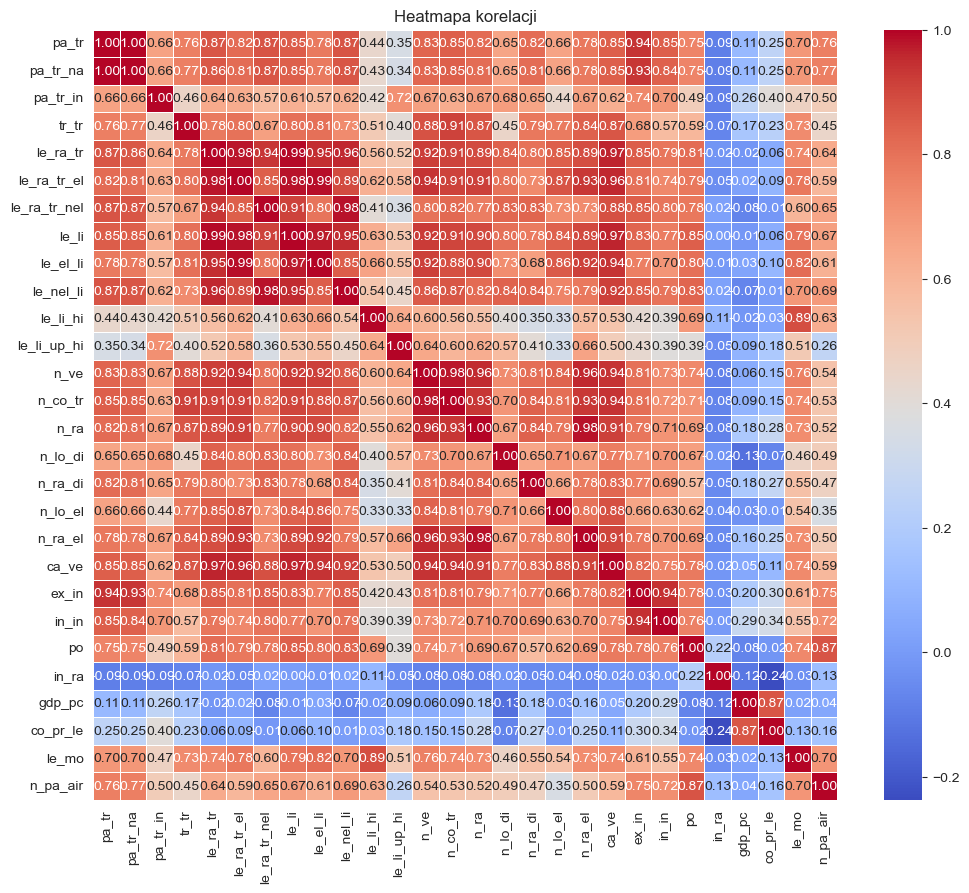

In [113]:
plt.figure(figsize=(12, 10))
correlation_matrix = tables.corr(numeric_only=True)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Heatmapa korelacji")
plt.show()

Na podstawie wykresów korelacji z naszą cechą określaną oraz mapy cieplnej, możemy dojść do wniosku, że większość naszych cech jest silnie skorelowana z liczbą pasażerów. Wyjątkiem są o dziwo cechy dotyczące ekonomii danego państwa, ponieważ istnieje bardzo słaba korelacja między inflacją i współczynnikiem PKB per capita a naszą klasą. Również współczynnik określający ceny w danym państwie nie ma tak dużego znaczenia, jak można było się spodziewać na początku.

Jednak z mapy cieplnej można wywnioskować także, że duża część cech jest skorelowana między sobą. Było to coś, czego również się spodziewaliśmy, ponieważ takie cechy jak np. długość linii kolejowych, a długość zelektryfikowanych linii kolejowych są silnie ze sobą powiązane. W związku z tym część cech na tym etapie też musimy usunąć z naszego zbioru.

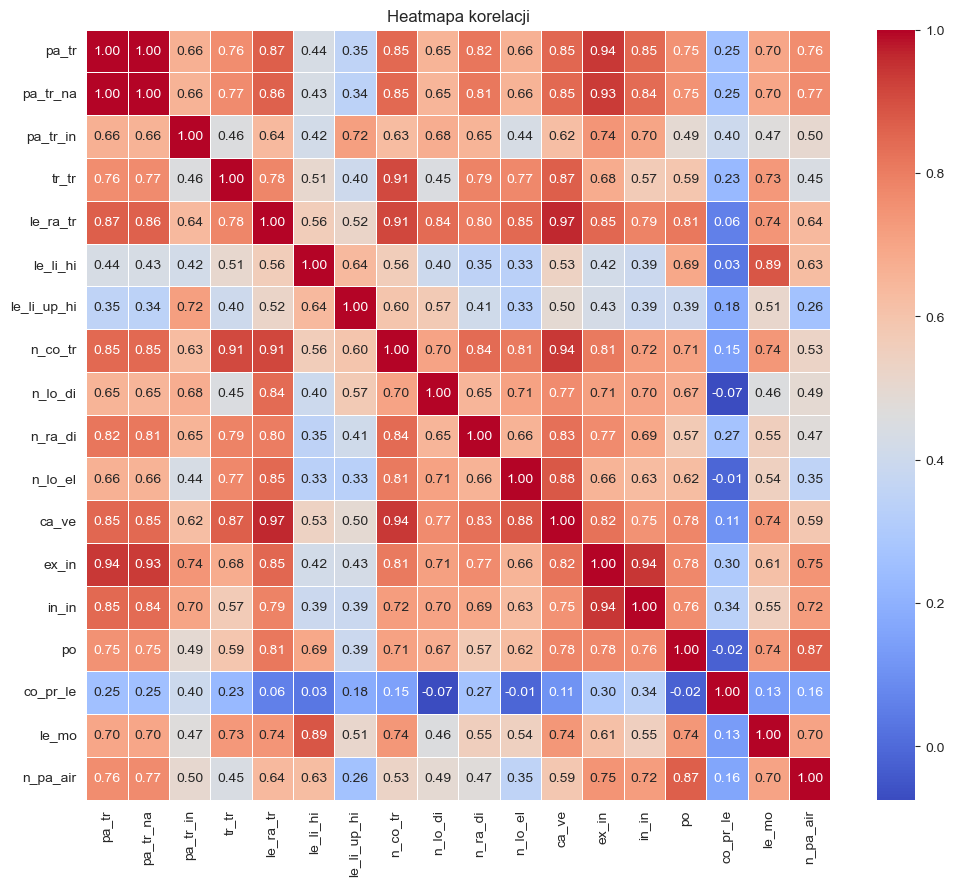

In [114]:
columns_to_drop = ['le_ra_tr_el', 'le_ra_tr_nel', 'le_li', 'le_nel_li', 'le_el_li',
                   'n_ve', 'n_ra', 'n_ra_el',
                   'gdp_pc', 'in_ra']
tables = tables.drop(columns=columns_to_drop)

# Heatmapa po zmianach
plt.figure(figsize=(12, 10))
correlation_matrix = tables.corr(numeric_only=True)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Heatmapa korelacji")
plt.show()

### 3. Trendy czasowe (wykresy liniowe).

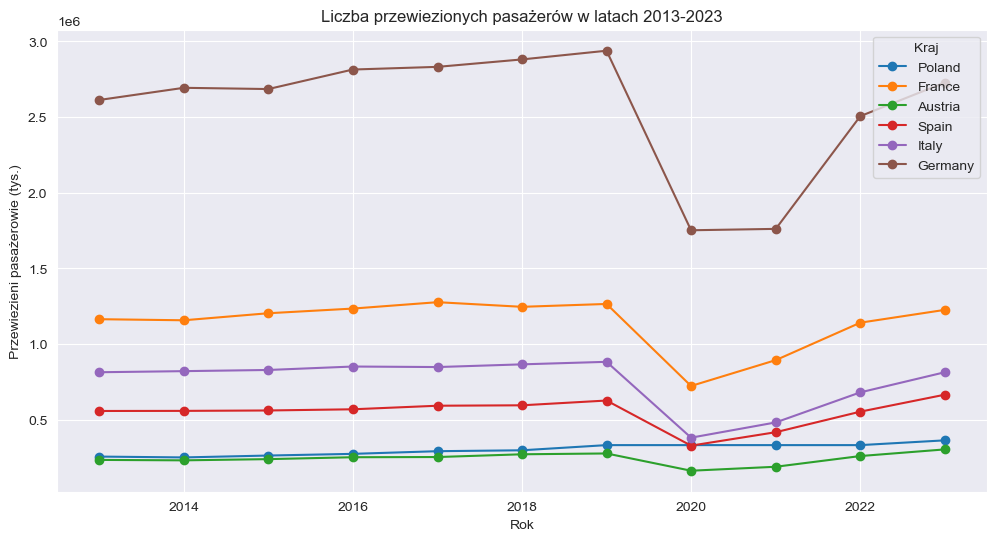

In [128]:
# Lista krajów do analizy
kraje = ['Poland', 'France','Austria', 'Spain', 'Italy', 'Germany']

plt.figure(figsize=(12, 6))
for kraj in kraje:
    subset = tables[tables['country'] == kraj]
    plt.plot(subset['year'], subset['pa_tr'], marker='o', label=kraj)

plt.title('Liczba przewiezionych pasażerów w latach 2013-2023')
plt.xlabel('Rok')
plt.ylabel('Przewiezieni pasażerowie (tys.)')
plt.legend(title='Kraj')
plt.grid(True)
plt.show()

Tendencja z roku na rok jest wyraźnie wzrostowa, jedynie w 2020 zaliczony został w każdym kraju znaczący spadek spowodowany pandemią COVID-19. Później z powrotem liczba pasażerów powoli zaczynała wzrastać i na tę chwilę w wielu państwach jest już nawet wyższa niż przed 2020 rokiem. W Polsce akurat dane w 2020 i 2021 nie były zbierane, więc ta linia prosta jest wynikiem uzupełnienia danych na podstawie ostatniej wartości, ale możemy się domyślić, że w tych latach Polska również zaliczyła spadek liczby pasażerów.

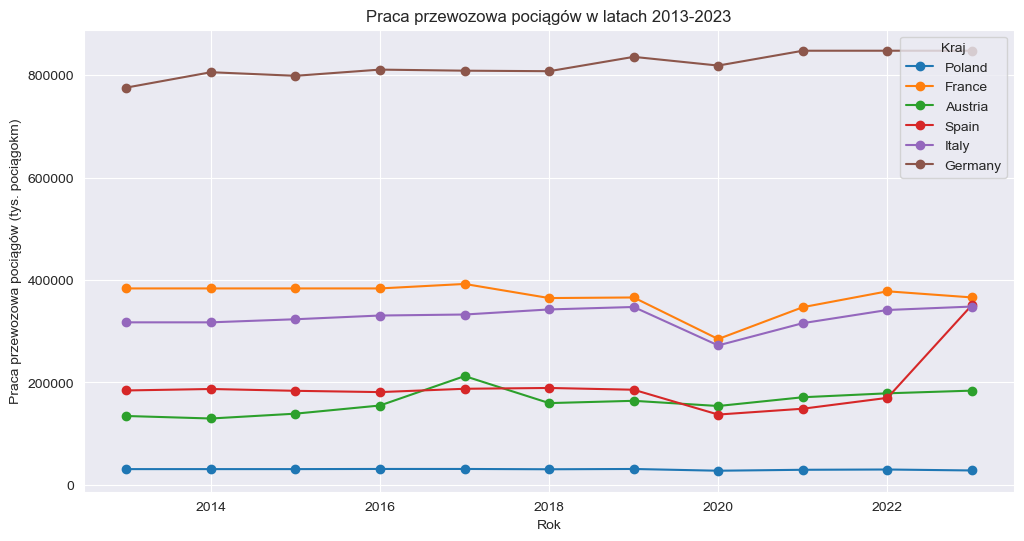

In [129]:
plt.figure(figsize=(12, 6))
for kraj in kraje:
    subset = tables[tables['country'] == kraj]
    plt.plot(subset['year'], subset['tr_tr'], marker='o', label=kraj)

plt.title('Praca przewozowa pociągów w latach 2013-2023')
plt.xlabel('Rok')
plt.ylabel('Praca przewozowa pociągów (tys. pociągokm)')
plt.legend(title='Kraj')
plt.grid(True)
plt.show()

Do ciekawych wniosków można dojść, porównując ten wykres z poprzednim, ponieważ wydawać by się mogło, że powinien wyjść bardzo podobny, a jednak np. praca przewozowa pociągów w Austrii jest dużo wyższa od tej w Polsce, pomimo że Austria przewozi rocznie mniej pasażerów niż Polska. Można więc wywnioskować, że w takim razie najprawdopodobniej w Austrii częstotliwość przejazdów musi być znacznie wyższa niż w Polsce.

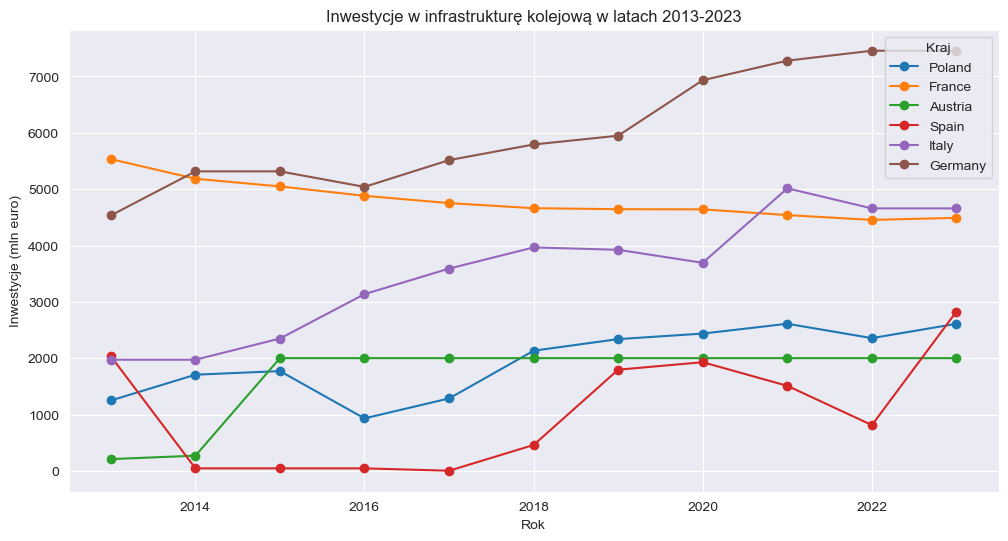

In [130]:
plt.figure(figsize=(12, 6))
for kraj in kraje:
    subset = tables[tables['country'] == kraj]
    plt.plot(subset['year'], subset['in_in'], marker='o', label={kraj})

plt.title('Inwestycje w infrastrukturę kolejową w latach 2013-2023')
plt.xlabel('Rok')
plt.ylabel('Inwestycje (mln euro)')
plt.legend(title='Kraj')
plt.grid(True)
plt.show()

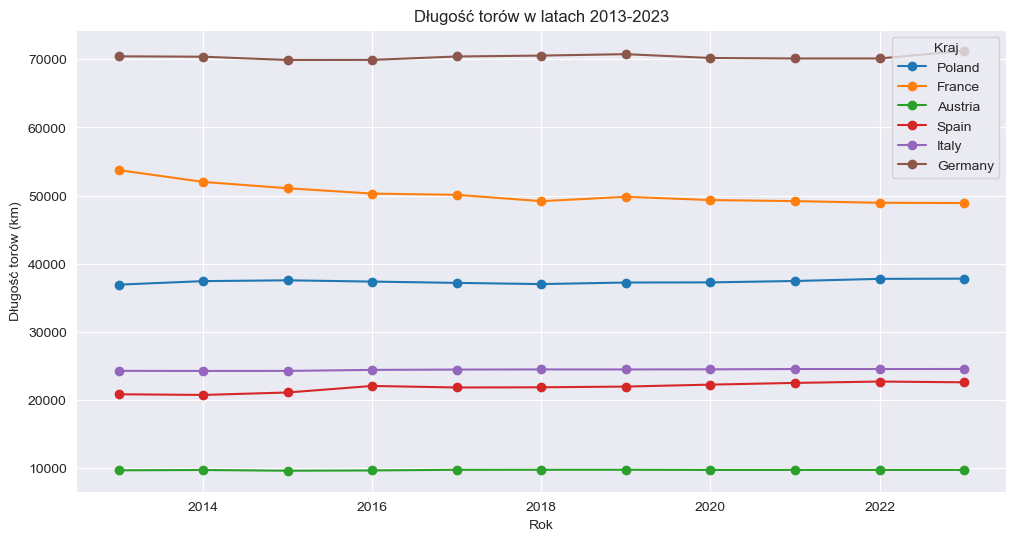

In [131]:
plt.figure(figsize=(12, 6))
for kraj in kraje:
    subset = tables[tables['country'] == kraj]
    plt.plot(subset['year'], subset['le_ra_tr'], marker='o', label={kraj})

plt.title('Długość torów w latach 2013-2023')
plt.xlabel('Rok')
plt.ylabel('Długość torów (km)')
plt.legend(title='Kraj')
plt.grid(True)
plt.show()

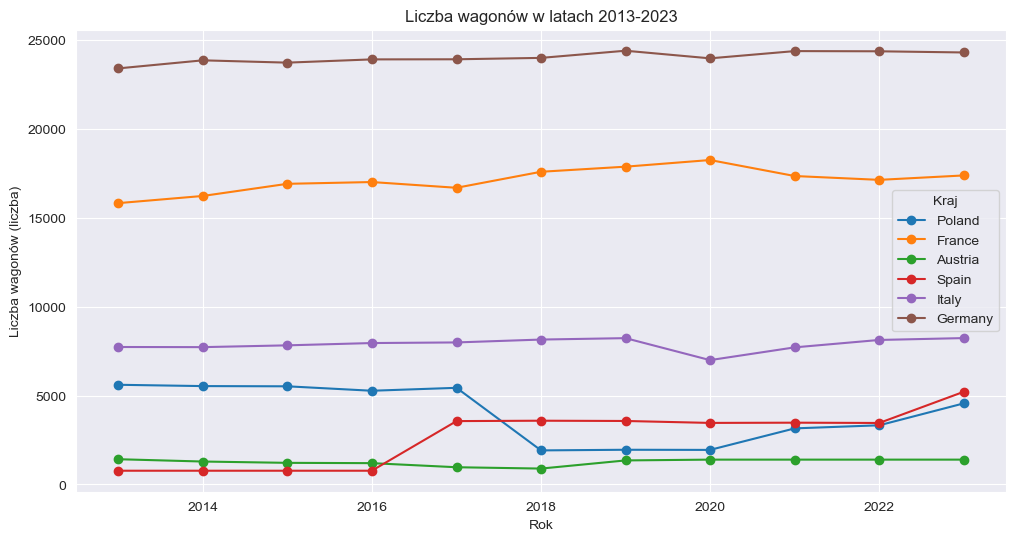

In [132]:
plt.figure(figsize=(12, 6))
for kraj in kraje:
    subset = tables[tables['country'] == kraj]
    plt.plot(subset['year'], subset['n_co_tr'], marker='o', label={kraj})

plt.title('Liczba wagonów w latach 2013-2023')
plt.xlabel('Rok')
plt.ylabel('Liczba wagonów (liczba)')
plt.legend(title='Kraj')
plt.grid(True)
plt.show()

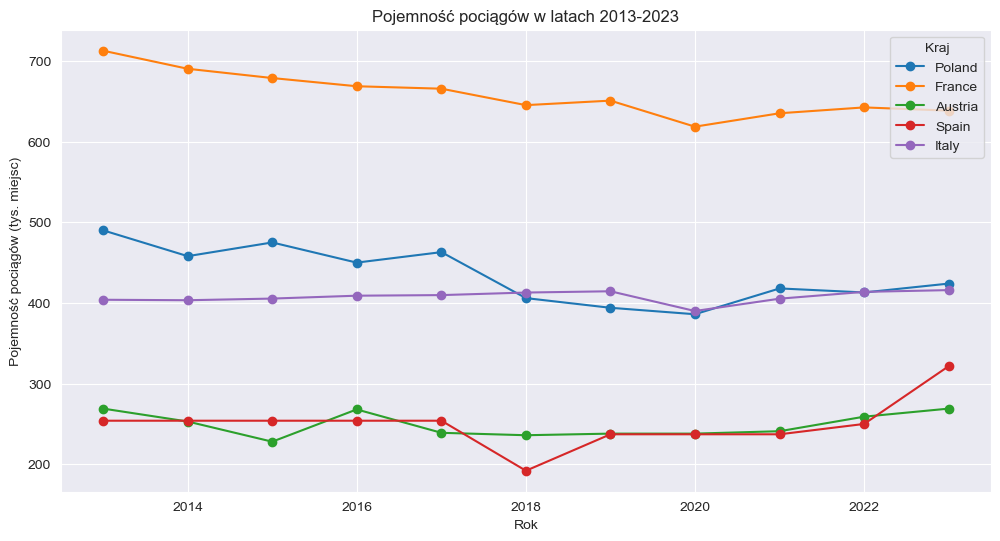

In [120]:
plt.figure(figsize=(12, 6))
for kraj in kraje:
    subset = tables[tables['country'] == kraj]
    plt.plot(subset['year'], subset['ca_ve'], marker='o', label=kraj)

plt.title('Pojemność pociągów w latach 2013-2023')
plt.xlabel('Rok')
plt.ylabel('Pojemność pociągów (tys. miejsc)')
plt.legend(title='Kraj')
plt.grid(True)
plt.show()

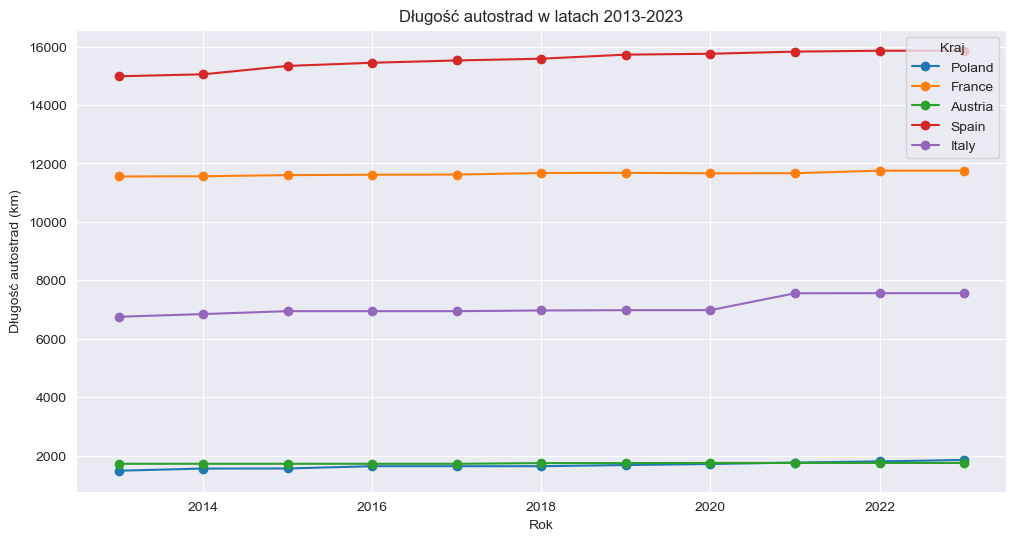

In [121]:
plt.figure(figsize=(12, 6))
for kraj in kraje:
    subset = tables[tables['country'] == kraj]
    plt.plot(subset['year'], subset['le_mo'], marker='o', label=kraj)

plt.title('Długość autostrad w latach 2013-2023')
plt.xlabel('Rok')
plt.ylabel('Długość autostrad (km)')
plt.legend(title='Kraj')
plt.grid(True)
plt.show()

### 4. Porównania między krajami (wykresy słupkowe).

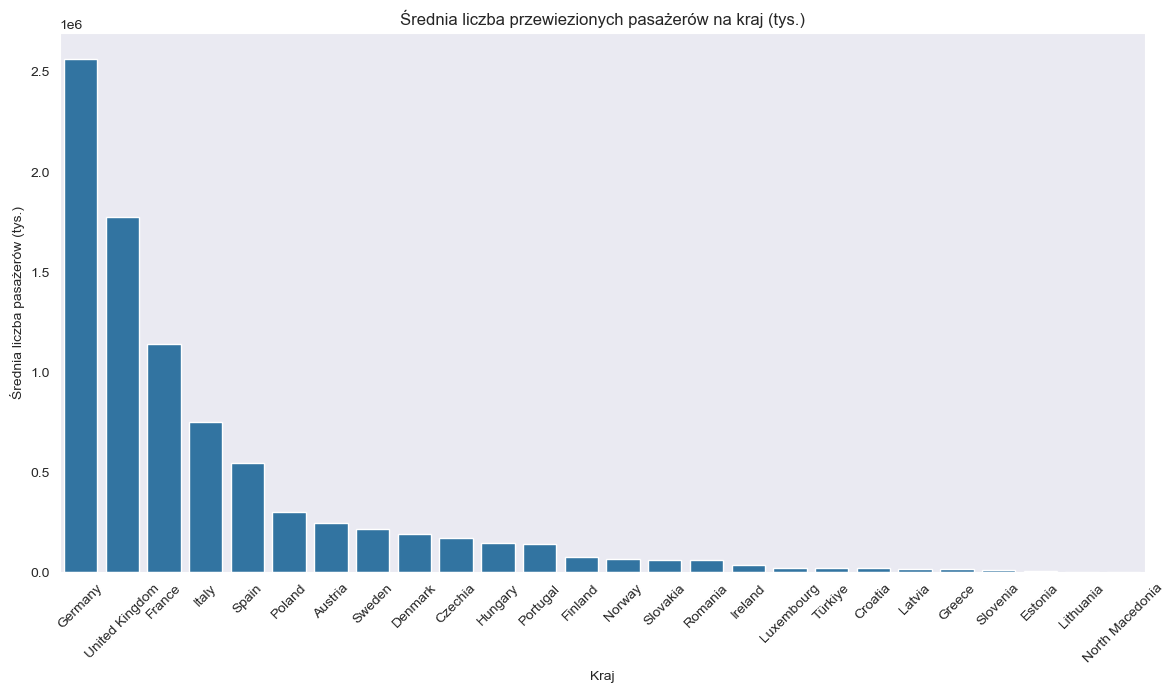

In [122]:
avg_passengers = tables.groupby('country')['pa_tr'].mean().sort_values(ascending=False)

plt.figure(figsize=(14, 7))
sns.barplot(x=avg_passengers.index, y=avg_passengers.values)

plt.title('Średnia liczba przewiezionych pasażerów na kraj (tys.)')
plt.xlabel('Kraj')
plt.ylabel('Średnia liczba pasażerów (tys.)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

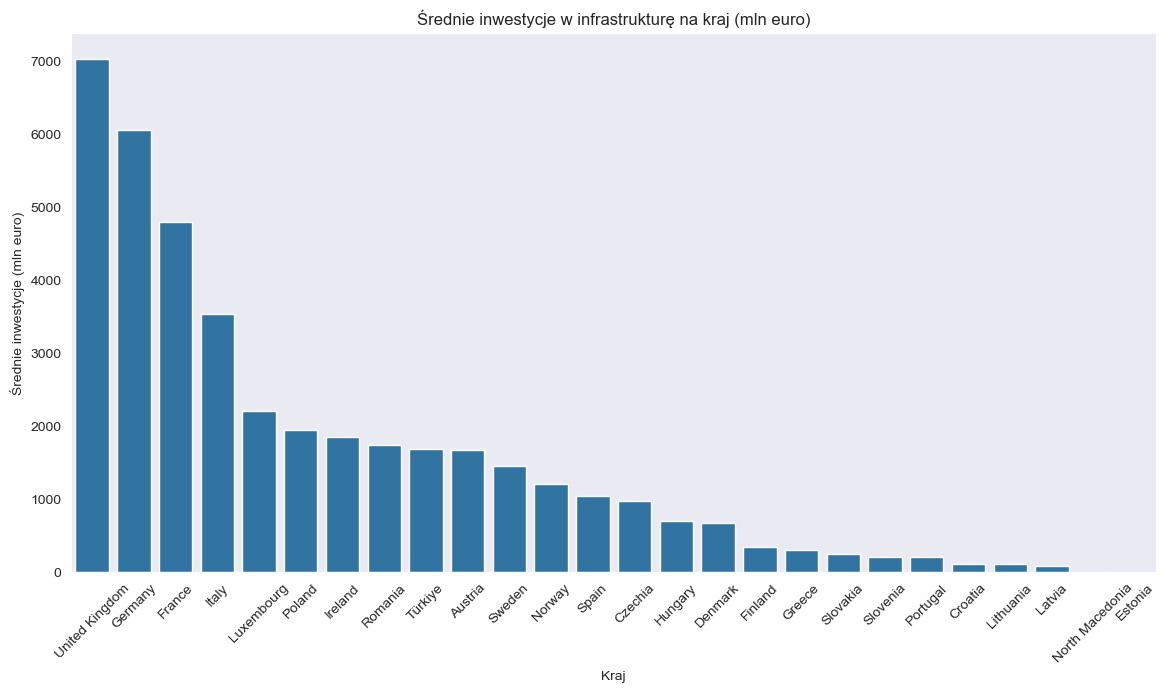

In [123]:
avg_investments = tables.groupby('country')['in_in'].mean().sort_values(ascending=False)

plt.figure(figsize=(14, 7))
sns.barplot(x=avg_investments.index, y=avg_investments.values)

plt.title('Średnie inwestycje w infrastrukturę na kraj (mln euro)')
plt.xlabel('Kraj')
plt.ylabel('Średnie inwestycje (mln euro)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

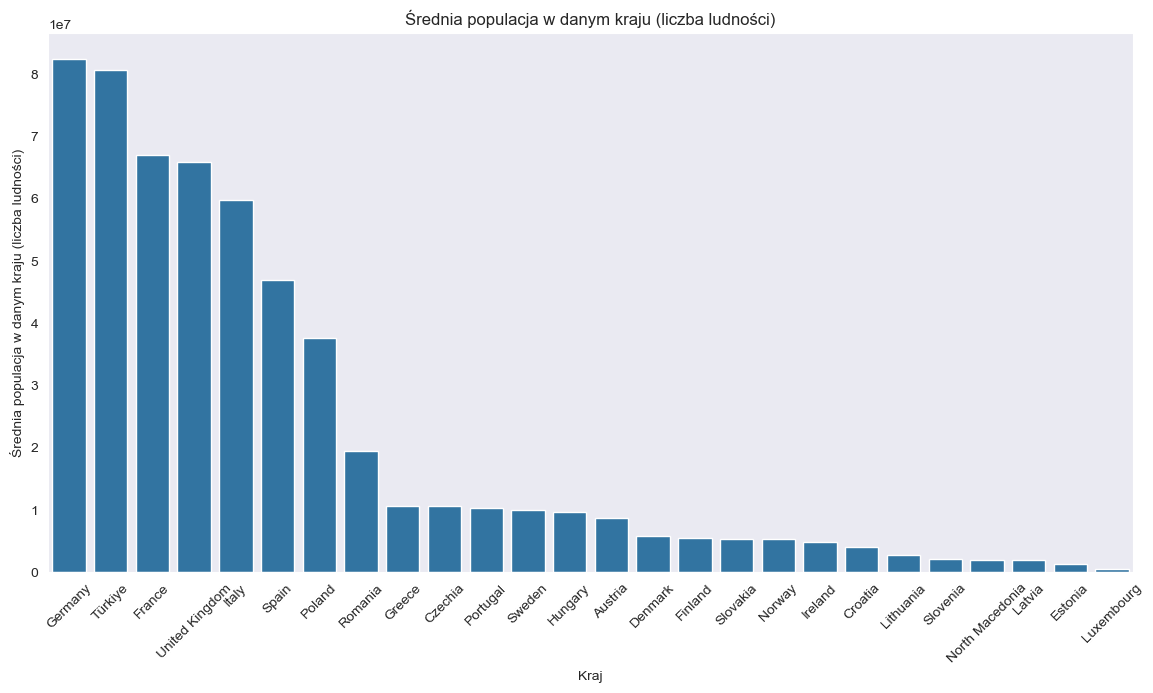

In [124]:
avg_population = tables.groupby('country')['po'].mean().sort_values(ascending=False)

plt.figure(figsize=(14, 7))
sns.barplot(x=avg_population.index, y=avg_population.values)

plt.title('Średnia populacja w danym kraju (liczba ludności)')
plt.xlabel('Kraj')
plt.ylabel('Średnia populacja w danym kraju (liczba ludności)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

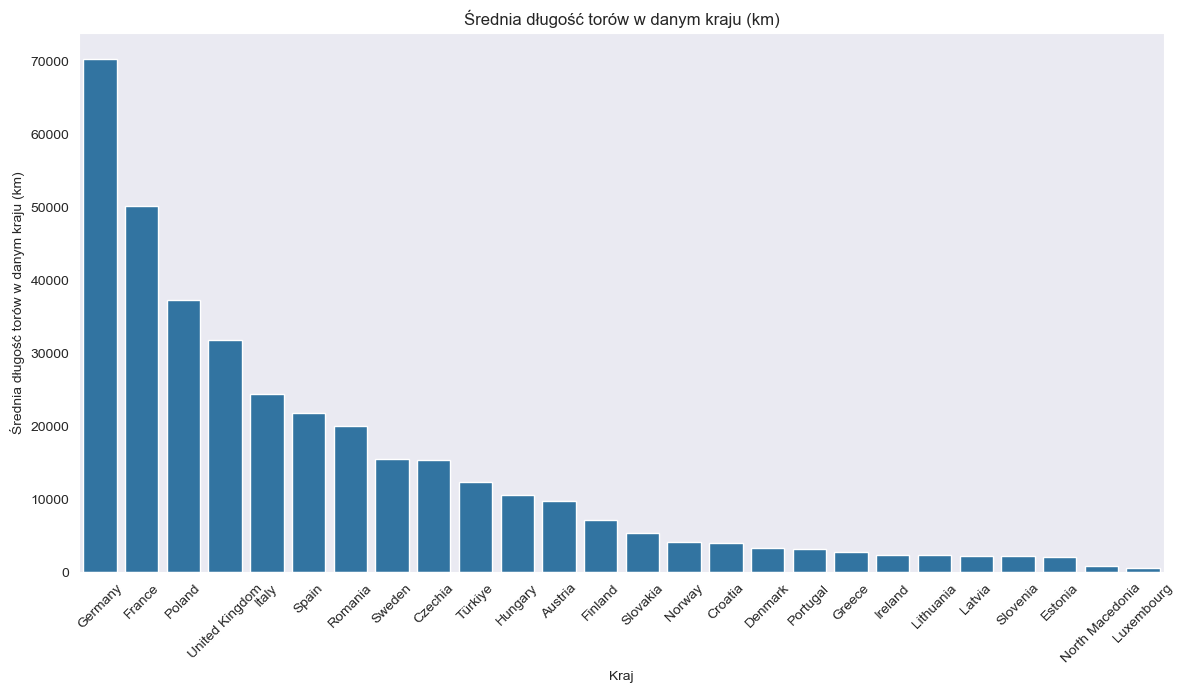

In [125]:
avg_tracks_length = tables.groupby('country')['le_ra_tr'].mean().sort_values(ascending=False)

plt.figure(figsize=(14, 7))
sns.barplot(x=avg_tracks_length.index, y=avg_tracks_length.values)

plt.title('Średnia długość torów w danym kraju (km)')
plt.xlabel('Kraj')
plt.ylabel('Średnia długość torów w danym kraju (km)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

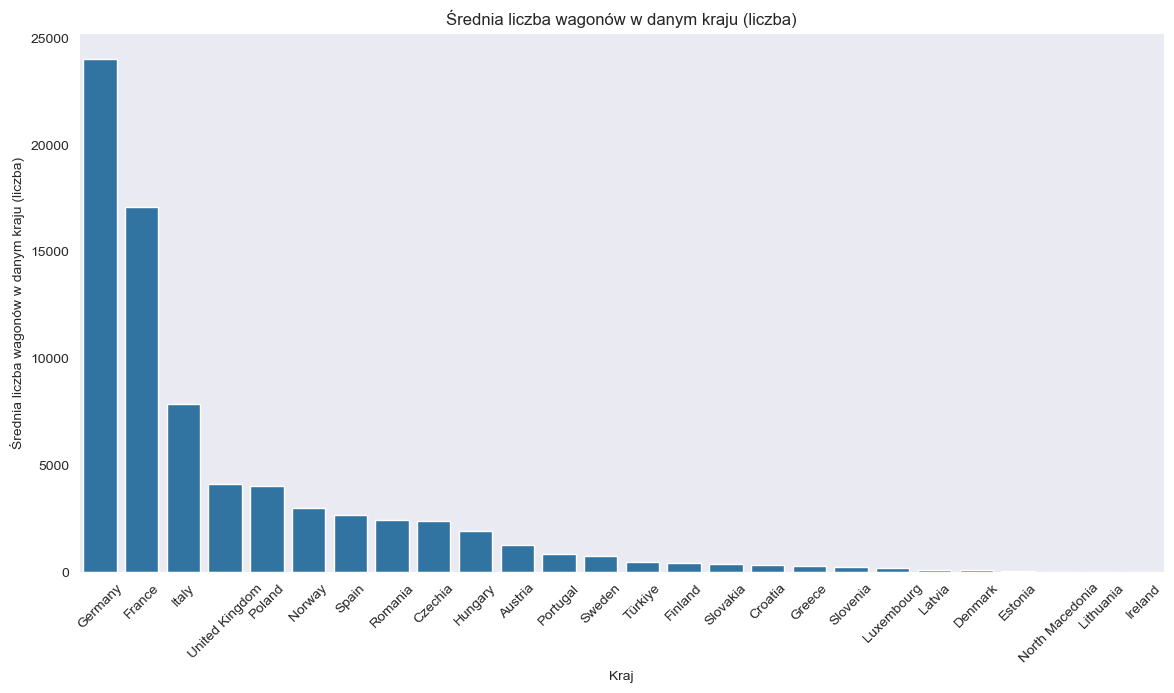

In [126]:
avg_trails_number = tables.groupby('country')['n_co_tr'].mean().sort_values(ascending=False)

plt.figure(figsize=(14, 7))
sns.barplot(x=avg_trails_number.index, y=avg_trails_number.values)

plt.title('Średnia liczba wagonów w danym kraju (liczba)')
plt.xlabel('Kraj')
plt.ylabel('Średnia liczba wagonów w danym kraju (liczba)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

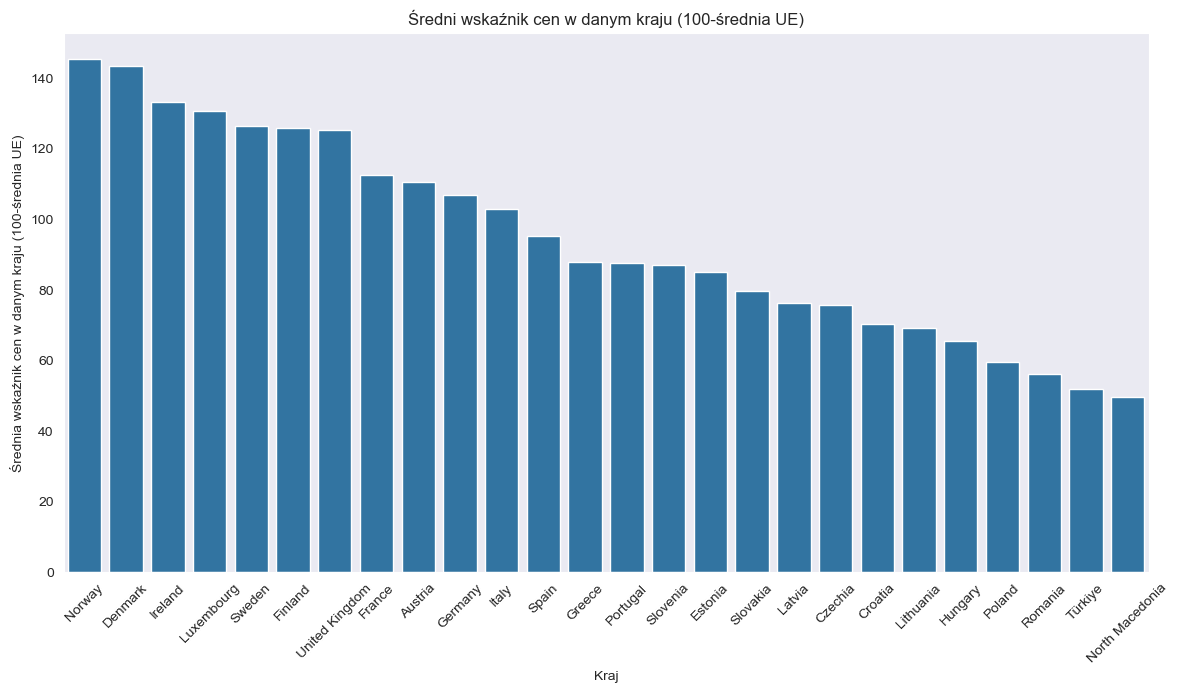

In [127]:
avg_pricing_index = tables.groupby('country')['co_pr_le'].mean().sort_values(ascending=False)

plt.figure(figsize=(14, 7))
sns.barplot(x=avg_pricing_index.index, y=avg_pricing_index.values)

plt.title('Średni wskaźnik cen w danym kraju (100-średnia UE)')
plt.xlabel('Kraj')
plt.ylabel('Średnia wskaźnik cen w danym kraju (100-średnia UE)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

## 7. Podsumowanie i wnioski

Analiza korelacji, wartości odstające, hipotezy